# Concentration as Covariate Test

In [3]:
import numpy as np
import torch
import seaborn as sns
import malt
import pandas as pd
import dgllife
import matplotlib.pyplot as plt

Using backend: pytorch


In [7]:
from tqdm import tqdm
from malt import Dataset, Point
from dgllife.utils import smiles_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer

# import dataframe
df = pd.read_csv('../../../data/data/moonshot_fluorescence_titration_curves.csv', index_col=0)

# index on unique smiles
df_smiles = df.reset_index().set_index(['SMILES', 'index'], inplace=False)

points = []
for smiles, titration_curve in tqdm(df_smiles.groupby(level=0)):
    
    # gather the titration in a dict of lists
    titration_dict = titration_curve.reset_index(drop=True).to_dict(orient='list')
    
    # convert graph from smiles
    g = smiles_to_bigraph(
        smiles = smiles,
        node_featurizer = CanonicalAtomFeaturizer(),
        edge_featurizer = CanonicalBondFeaturizer()
    )
    
    # make point object
    point = Point(
        smiles = smiles,
        g = g,
        y = torch.randn(1),
        extra = titration_dict
    )
    
    # append
    points.append(point)
    
# create dataset
data = Dataset(points)

100%|██████████████████████████████████████| 2281/2281 [00:07<00:00, 290.94it/s]


In [8]:
data

Dataset with 2281 points

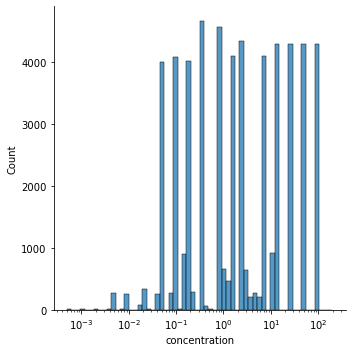

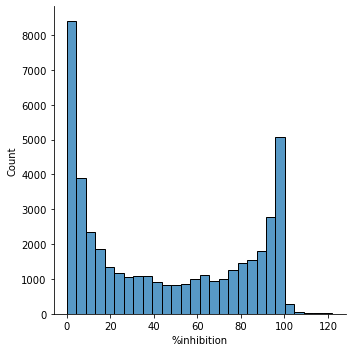

In [221]:
sns.displot(
    df,
    x='concentration',
    log_scale=True
)

sns.displot(
    df.query('`%inhibition` > 0.0'),
    x='%inhibition'
)

In [9]:
from malt.data.collections import _dataset_from_dgllife
data.shuffle(seed=2666)
ds_tr, ds_vl, ds_te = data[:1500].split([8, 1, 1])

Make model

In [10]:
model_choice = 'gp' # 'nn'

if model_choice == "gp":
    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.ExactGaussianProcessRegressor(
            in_features=128, out_features=2,
        ),
        likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
    )


elif model_choice == "nn":
    model = malt.models.supervised_model.SimpleSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.NeuralNetworkRegressor(
            in_features=128, out_features=1,
        ),
        likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
    )

Train and evaluate.

In [11]:
trainer = malt.trainer.get_default_trainer(
    without_player=True,
    batch_size=len(ds_tr), # len(ds_tr),
    n_epochs=50,
    learning_rate=1e-3
)
model = trainer(model, ds_tr)

r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
print(rmse)

tensor(-0.1746, grad_fn=<RsubBackward1>)
tensor(1.0871, grad_fn=<SqrtBackward0>)


c:\users\micha\dev\choderalab\malt\malt\metrics\base_metrics.py:10: UserWarning: Using a target size (torch.Size([150])) that is different to the input size (torch.Size([150, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(torch.nn.functional.mse_loss(target, input))


In [12]:
ds_te_loader = ds_te.view(batch_size=len(ds_te))
g, y = next(iter(ds_te_loader))

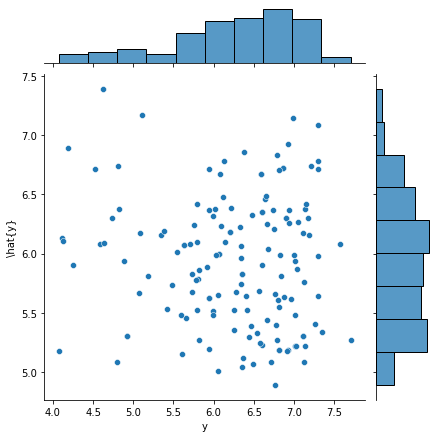

In [12]:
ds_te_loader = ds_te.view(batch_size=len(ds_te))
g, y = next(iter(ds_te_loader)) 
y_hat = model.condition(g).mean
g = sns.jointplot(x = ds_te.y, y = y_hat.detach().numpy().ravel())
g.set_axis_labels('y', '\hat{y}')

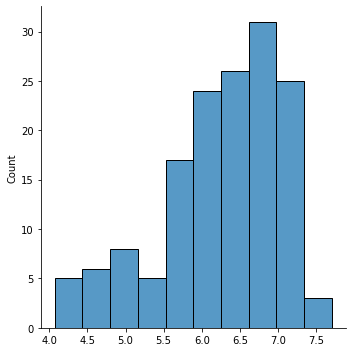

In [14]:
sns.displot(ds_te.y)

In [13]:
import torch
import dgl
import malt
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--data", type=str, default="esol")
parser.add_argument("--model", type=str, default="nn")

args = parser.parse_args([])

data = getattr(malt.data.collections, args.data)()
data.shuffle(seed=2666)
ds_tr, ds_vl, ds_te = data.split([8, 1, 1])

if args.model == "gp":
    model = malt.models.supervised_model.GaussianProcessSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.ExactGaussianProcessRegressor(
            in_features=128, out_features=2,
        ),
        likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
    )


elif args.model == "nn":
    model = malt.models.supervised_model.SimpleSupervisedModel(
        representation=malt.models.representation.DGLRepresentation(
            out_features=128,
        ),
        regressor=malt.models.regressor.NeuralNetworkRegressor(
            in_features=128, out_features=1,
        ),
        likelihood=malt.models.likelihood.HomoschedasticGaussianLikelihood(),
    )


trainer = malt.trainer.get_default_trainer(without_player=True, batch_size=len(ds_tr), n_epochs=3000, learning_rate=1e-3)
model = trainer(model, ds_tr)

r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
print(rmse)

Processing dgl graphs from scratch...
Processing molecule 1000/1128
tensor(0.9217, grad_fn=<RsubBackward1>)
tensor(2.8730, grad_fn=<SqrtBackward0>)


c:\users\micha\dev\choderalab\malt\malt\metrics\base_metrics.py:10: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(torch.nn.functional.mse_loss(target, input))


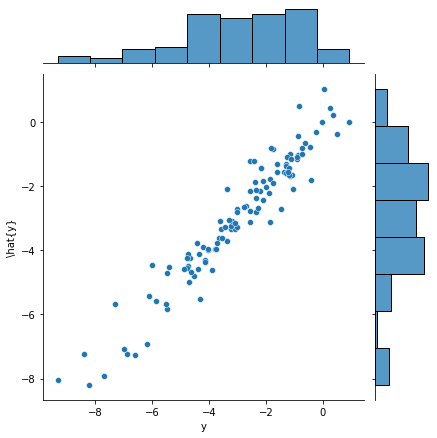

In [16]:
ds_te_loader = ds_te.view(batch_size=len(ds_te))
g, y = next(iter(ds_te_loader))
y_hat = model.condition(g).mean
g = sns.jointplot(x = ds_te.y, y = y_hat.detach().numpy())
g.set_axis_labels('y', '\hat{y}')